# Synthesizing Adversarial Examples
This notebook is a simple environment containing the following: 
* ImageNet loading
* SqueezeNet classification model trained on ImageNet
* Simple gradient based adversarial image generation technique
* Experiments which test the impact if linear transformation to adversarial images

In this notebook, we are mostly concerned with modifying the adversarial images until they are correctly classified again. However, the eventual goal of these experiments is to generate adversarial examples by following the expected value of the gradient of the model loss w.r.t the linearly transformed images. This technique has been highlighted in *Synthesizing Robust Adversarial Examples* by Athalye and Sutskever

In [1]:
from __future__ import print_function
import time, os, json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from cs231n.classifiers.squeezenet import SqueezeNet
from cs231n.data_utils import load_tiny_imagenet
from cs231n.image_utils import preprocess_image, deprocess_image
from cs231n.image_utils import SQUEEZENET_MEAN, SQUEEZENET_STD


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def get_session():
    """Create a session that dynamically allocates memory."""
    # See: https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
tf.reset_default_graph()
sess = get_session()

SAVE_PATH = 'cs231n/datasets/squeezenet.ckpt'
# if not os.path.exists(SAVE_PATH):
#     raise ValueError("You need to download SqueezeNet!")
model = SqueezeNet(save_path=SAVE_PATH, sess=sess)

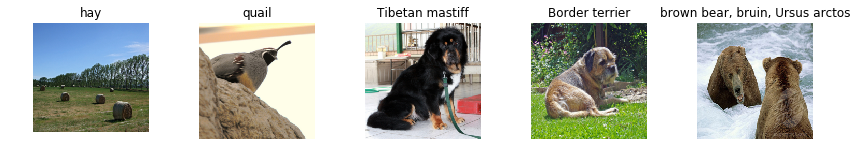

In [3]:
from cs231n.data_utils import load_imagenet_val
X_raw, y, class_names = load_imagenet_val(num=5)

plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_raw[i])
    plt.title(class_names[y[i]])
    plt.axis('off')
plt.gcf().tight_layout()

In [4]:
X = np.array([preprocess_image(img) for img in X_raw])

In [5]:
# Generate a fooling image X_fooling that the model will classify as   
# the class target_y. Use gradient ascent on the target class score, using   
# the model.classifier Tensor to get the class scores for the model.image.   
# When computing an update step, first normalize the gradient:               
#   dX = learning_rate * g / ||g||_2                                         
def make_fooling_image(X, target_y, model):
    """
    Generate a fooling image that is close to X, but that the model classifies
    as target_y.

    Inputs:
    - X: Input image, of shape (1, 224, 224, 3)
    - target_y: An integer in the range [0, 1000)
    - model: Pretrained SqueezeNet model

    Returns:
    - X_fooling: An image that is close to X, but that is classifed as target_y
    by the model.
    """
    X_fooling = X.copy()
    learning_rate = 1
    i, y_pred = 0, 1000
    while target_y != y_pred and i < 100:
        new_grad = tf.gradients(model.loss, model.image)
        out = sess.run([new_grad, model.classifier, model.loss], 
                        feed_dict={model.image: X_fooling,
                                   model.labels : np.array([target_y])})
        dX = learning_rate * out[0][0] / np.sqrt(np.sum(out[0][0]**2))
        X_fooling -= dX
        y_pred = np.argmax(out[1], axis=1)
        i += 1
    return X_fooling

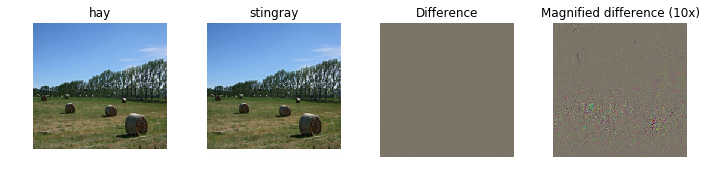

In [6]:
idx = 0
Xi = X[idx][None]
target_y = 6
X_fooling = make_fooling_image(Xi, target_y, model)

# Make sure that X_fooling is classified as y_target
scores = sess.run(model.classifier, {model.image: X_fooling})
assert scores[0].argmax() == target_y, 'The network is not fooled!'

# Show original image, fooling image, and difference
orig_img = deprocess_image(Xi[0])
fool_img = deprocess_image(X_fooling[0])
# Rescale 
plt.subplot(1, 4, 1)
plt.imshow(orig_img)
plt.axis('off')
plt.title(class_names[y[idx]])
plt.subplot(1, 4, 2)
plt.imshow(fool_img)
plt.title(class_names[target_y])
plt.axis('off')
plt.subplot(1, 4, 3)
plt.title('Difference')
plt.imshow(deprocess_image((Xi-X_fooling)[0]))
plt.axis('off')
plt.subplot(1, 4, 4)
plt.title('Magnified difference (10x)')
plt.imshow(deprocess_image(10 * (Xi-X_fooling)[0]))
plt.axis('off')
plt.gcf().tight_layout()

# Impact of Linear Transformations to Adversarial Images
Take the adversarial image taken above. Then apply some linear transformations to it.
Does the image still get misclassified? 

### Transformation 1: Image Blurring
Applying a Gaussian Blur to the adversarial image causes it to be reclassified with the correct class. 
However, the `blurring_factor` is an important hyperparameter that should be tuned over the entire data set

In [7]:
import scipy.ndimage as ndi
def blur_image(image, blurring_factor=0.6):
    blurred_image = ndi.filters.gaussian_filter(image, blurring_factor)
    return blurred_image

In [8]:
adversarial_image = X_fooling[0]
blurred_image = blur_image(adversarial_image)
blurred_image_reshaped = blurred_image.reshape((1, *(blurred_image.shape)))
class_scores_for_blurred_image = sess.run(model.classifier, {model.image: blurred_image_reshaped})
label_blurred_image = class_scores_for_blurred_image[0].argmax()

(-0.5, 223.5, 223.5, -0.5)

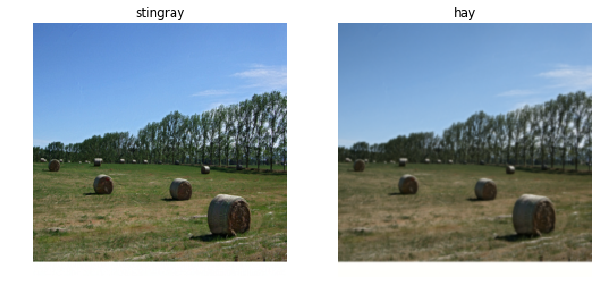

In [9]:
plt.subplot(1, 2, 1)
plt.imshow(deprocess_image(adversarial_image))
plt.title(class_names[scores[0].argmax()])
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(deprocess_image(blurred_image))
plt.title(class_names[label_blurred_image])
plt.axis('off')

### Translation 2: Rotation
Applying a rotation to the adversarial image causes it to be recalssified with the correct label. Again, the degree of rotation is an important hyperparameter that should be tuned over the entire dataset. 

In [10]:
def rotate_image(image, degrees=10):
    return ndi.interpolation.rotate(input=image, angle=degrees)

#### First, we show if we rotate the original (clean, non-adversarial) image, the SqeezeNet model is still able to correctly classify the image

In [11]:
original_image = X[0][None][0]
scores_original_image = sess.run(model.classifier, {
        model.image : original_image.reshape((1, *(original_image.shape)))
    })
label_original_image = scores_original_image[0].argmax()
label_name_original_image = class_names[label_original_image]
print('Original Image Class: ', label_name_original_image)

Original Image Class:  hay


In [12]:
rotated_image = rotate_image(original_image)
scores_rotated_image = sess.run(model.classifier, {
        model.image : rotated_image.reshape((1, *(rotated_image.shape)))
    })
label_rotated_image = scores_rotated_image[0].argmax()
label_name_rotated_image = class_names[label_rotated_image]
print('Rotated Image Class: ', label_name_rotated_image)

Rotated Image Class:  hay


#### Now we show that rotating the *adversarial image*, causes it to be assigned to its original (correct) class

In [13]:
rotated_adversarial_image = rotate_image(adversarial_image)
scores_adv_rotated_image = sess.run(model.classifier, {
        model.image : rotated_adversarial_image.reshape((1, *(rotated_adversarial_image.shape)))
    })
label_adv_rotated_image = scores_adv_rotated_image[0].argmax()
label_name_adv_rotated_image = class_names[label_adv_rotated_image]
print('Rotated Adversarial Image Class: ', label_name_adv_rotated_image)

Rotated Adversarial Image Class:  hay


(-0.5, 258.5, 258.5, -0.5)

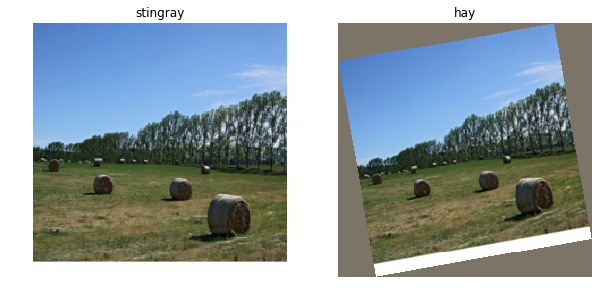

In [14]:
plt.subplot(1, 2, 1)
plt.imshow(deprocess_image(adversarial_image))
plt.title(class_names[scores[0].argmax()])
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(deprocess_image(rotated_image))
plt.title(class_names[label_adv_rotated_image])
plt.axis('off')

### Transformation 3: Scaling / Zooming
We will scale the adversarial exmaple and verify that the scaled image is classified correctly. 
As always, we need to ensure that scaling the original image by the same amount continues to yield the same (correct) classification

In [ ]:
def scale_image(image, scaling_factor=0.3):
    crop = image[74:, 37:187, :]
    return ndi.interpolation.zoom(crop, zoom=[scaling_factor, scaling_factor, 1])

In [ ]:
scaled_image = scale_image(original_image)
scores_scaled_image = sess.run(model.classifier, {
        model.image : scaled_image.reshape((1, *(scaled_image.shape)))
    })
label_scaled_image = scores_scaled_image[0].argmax()
label_name_scaled_image = class_names[label_scaled_image]
print('Rotated Image Class: ', label_name_scaled_image)